## 0. Importing Pytorch and setting up device agnostic code

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.0+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class.

Our dataset starts with 3 classes of food and only 10% of the images.

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists...")
else:
  print(f"{image_path} does not exists, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading dataset...")
  f.write(request.content)

# Unzip file
with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping dataset...")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi directory already exists...
Unzipping dataset...


## 2. Becoming One with the Data (Data Prepation and Data Exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing Image

1. Get all of the image paths
2. Pick a random image path using python's `random.chocie()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/steak/2013535.jpg
Image class: steak
Image height: 512
Image width: 512


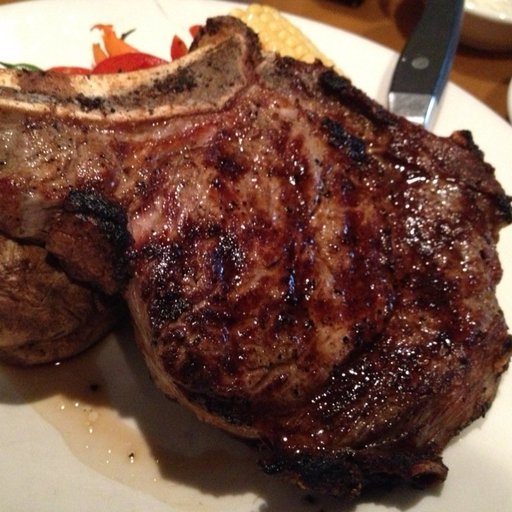

In [7]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all of the image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # we want all of them

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

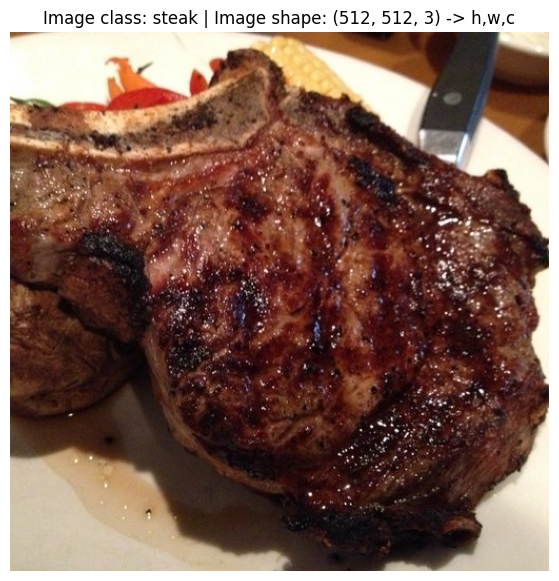

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> h,w,c")
plt.axis(False)

## 3. Transforming Data

Before we can use our image data with PyTorch:

1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn in to a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `DataLoader`.


In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used a model/perform data augmentation

`Note: 224x224 is also commanly used`

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img)

tensor([[[0.9412, 0.9686, 0.9804,  ..., 0.8980, 0.8314, 0.7569],
         [0.9451, 0.9529, 0.9255,  ..., 0.9922, 0.9882, 0.9804],
         [0.7451, 0.6784, 0.5686,  ..., 0.9922, 0.9961, 0.9961],
         ...,
         [0.8431, 0.8353, 0.8314,  ..., 0.8039, 0.8039, 0.8000],
         [0.8275, 0.8235, 0.8196,  ..., 0.7961, 0.7922, 0.7882],
         [0.8235, 0.8196, 0.8157,  ..., 0.7843, 0.7804, 0.7804]],

        [[0.8863, 0.9137, 0.9333,  ..., 0.8431, 0.7373, 0.6431],
         [0.9020, 0.9098, 0.8706,  ..., 0.9843, 0.9804, 0.9647],
         [0.6745, 0.5961, 0.4588,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.8000, 0.7882, 0.7804,  ..., 0.7569, 0.7569, 0.7529],
         [0.7922, 0.7804, 0.7765,  ..., 0.7490, 0.7490, 0.7490],
         [0.7882, 0.7725, 0.7686,  ..., 0.7373, 0.7373, 0.7412]],

        [[0.7529, 0.7725, 0.7961,  ..., 0.7490, 0.6235, 0.4980],
         [0.7843, 0.7961, 0.7608,  ..., 0.9098, 0.9059, 0.8824],
         [0.5804, 0.5020, 0.3647,  ..., 0.9373, 0.9529, 0.

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

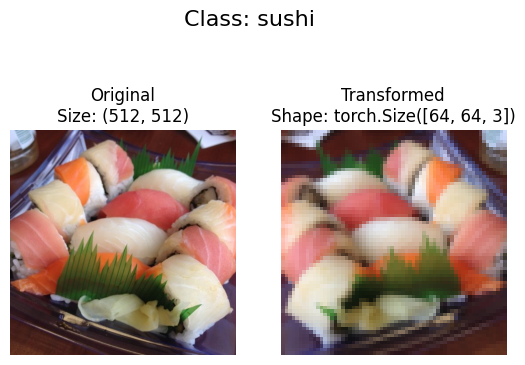

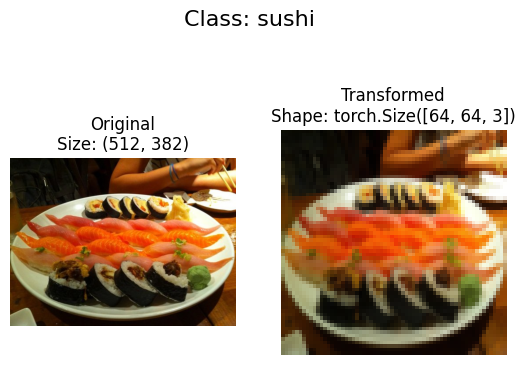

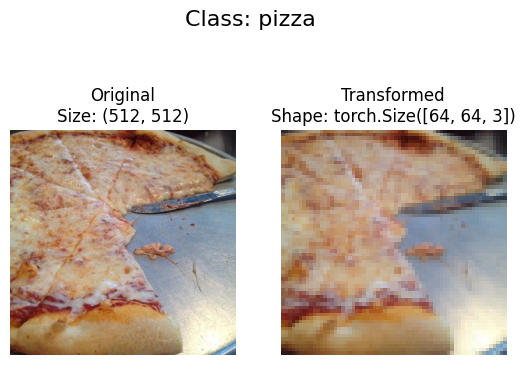

In [13]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`


In [14]:
# Use ImageFolder to create dataset

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lenghts of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> c,h,w
Image permute: torch.Size([64, 64, 3]) -> h,w,c


Text(0.5, 1.0, 'pizza')

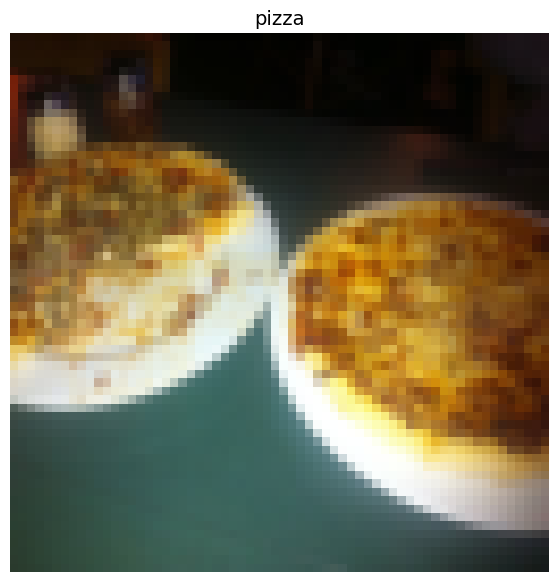

In [20]:
# Rearrange the order of dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> c,h,w")
print(f"Image permute: {img_permute.shape} -> h,w,c")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded image into Dataloaders

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customise the `batch_size` images at a time.

Batch is important otherwise we can run out of memory.



In [21]:
# Turn train and test dataset into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader



(<torch.utils.data.dataloader.DataLoader at 0x7a26ddbf3ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a26ddba1c30>)

In [22]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [23]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [bathc_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [bathc_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom Dataset

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writting more code, which could be prone to errors or performance issues.


In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir()` to traverse a target directory.
2. Raise an error if the class names aren't found.
3. Turn the class names into a dict and list and return them.



In [26]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """ Finds the classes folder names in a target directory
  """
  # 1. Get the class names by scanning the target dir
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")
  # 3. Create a dictionary of index labels (for computing)
  class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
  return classes, class_to_idx


In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init out subclass with a target directory as well as a transform if we'd like to transform our data
3. Create several attributes:
  * paths - paths of our images
  * transforms - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labes
4. Create a function to `load_images()`
5. Overwrite the `__len()__ `method
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [29]:
# Write a custom dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self,index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    # Returns the total number of samples
    return len(self.paths)

  # 6. Overwrite __getitem()__ to return a particular sample
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label(X,y)
    else:
      return img, class_idx


In [30]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [31]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [32]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a26ddbf3190>,
 <__main__.ImageFolderCustom at 0x7a26ddbf3c10>)

In [33]:
len(train_data), len(train_data_custom)

(225, 225)

In [34]:
len(test_data), len(test_data_custom)

(75, 75)

In [35]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [36]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [37]:
# Check for equality between original ImageFolder and Custom
print(test_data_custom.classes==test_data.classes)

True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure dim of our iamges line up with matplotlib

In [38]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n=10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
  # 3. Set the seed
  if seed:
    random.seed(seed)
  # 4. Get random sample idx
  random_sample_idx = random.sample(range(len(dataset)), k=n)
  # 5. Setup plot
  plt.figure(figsize=(16,8))
  # 6. Loop through to idx and plot
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # 7. Adjust tensor dim for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # c,h,w -> h,w,c
    # Plot
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


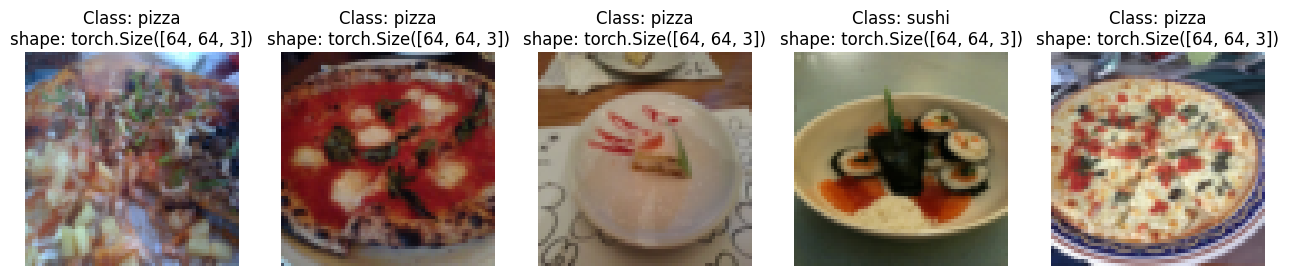

In [39]:
# Display random images form the ImageFolder created Dataset (Option 1)
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


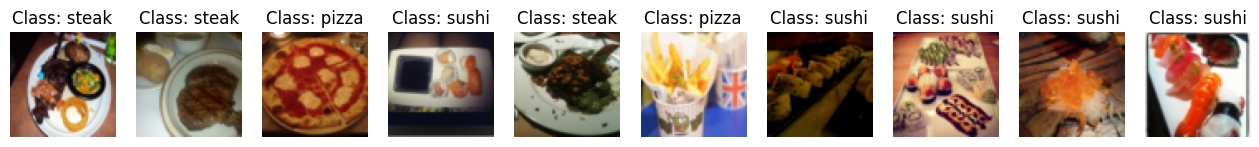

In [40]:
# Display random images form the ImageFolderCustom Dataset (Option 2)
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader` s

In [41]:
BATCH_SIZE =32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)

In [42]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a26dcfe3070>,
 <torch.utils.data.dataloader.DataLoader at 0x7a26dcfe3880>)

In [43]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other Forms of Transforms (Data Augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean appliyng various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...



In [44]:
# Let's look at TrivialAugment - leverages the power of randomness

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [45]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

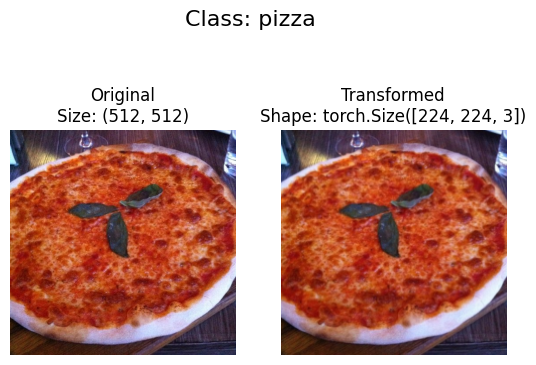

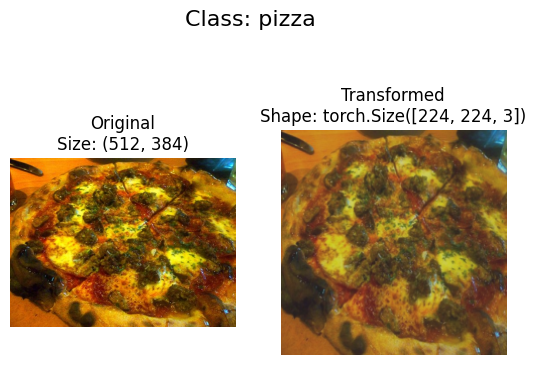

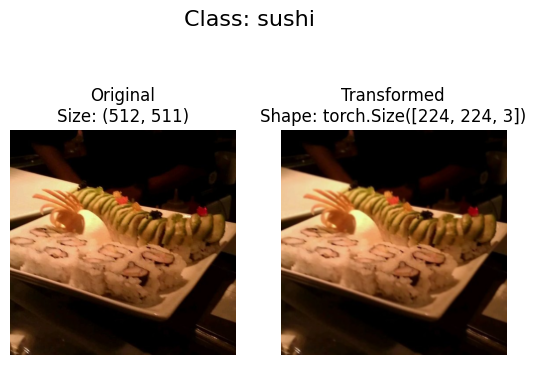

In [46]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without Data Augmentation

### 7.1 Creating transforms and loading data for Model 0

In [47]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [48]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG Model Class


In [49]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x= self.classifier(x)
    #print(x.shape)
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [50]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,# nr of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image - To detect input_shape of classifier layer

In [51]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [52]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [53]:
pip install torchinfo

In [54]:
from torchinfo import summary

summary(model_0, input_size=(BATCH_SIZE, 3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create train and test loops

In [55]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  # Put the model in train mode
  model.train()
  # Setup train loss and train accuracy values
  train_loss, train_acc = 0,0
  # Loop through data loader
  for batch, (X,y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)
    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    # Optimizer zero grad
    optimizer.zero_grad()
    # Loss backward
    loss.backward()
    # Optimizer stem
    optimizer.step()

    # Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [56]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device = device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy
  test_loss, test_acc = 0,0
  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader
    for batch, (X,y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)
      # Forward pass
      test_pred_logits = model(X)
      # Calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()
      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
  # Adjust metrics to get average loss and accuracy
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine train and test step

In [57]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
  # Empty results dictionary to track our results
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  # Loop through training and testing steps for a nr of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # Print out whats happening
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the filled results
  return results

### 7.7 Train and Evaluate Model_0

In [58]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

# Recrate and instance of TinyVGG

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape= len(train_data.classes)).to(device)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1063 | Train Acc: 0.3047 | Test Loss: 1.0983 | Test Acc: 0.3011
Epoch: 1 | Train Loss: 1.0998 | Train Acc: 0.3281 | Test Loss: 1.0697 | Test Acc: 0.5417
Epoch: 2 | Train Loss: 1.0869 | Train Acc: 0.4883 | Test Loss: 1.0808 | Test Acc: 0.4924
Epoch: 3 | Train Loss: 1.0843 | Train Acc: 0.4023 | Test Loss: 1.0608 | Test Acc: 0.5833
Epoch: 4 | Train Loss: 1.0662 | Train Acc: 0.4102 | Test Loss: 1.0655 | Test Acc: 0.5644
Epoch: 5 | Train Loss: 1.0302 | Train Acc: 0.4375 | Test Loss: 1.0136 | Test Acc: 0.5426
Epoch: 6 | Train Loss: 0.9828 | Train Acc: 0.4180 | Test Loss: 0.9315 | Test Acc: 0.6146
Epoch: 7 | Train Loss: 0.9589 | Train Acc: 0.5859 | Test Loss: 1.0079 | Test Acc: 0.4640
Epoch: 8 | Train Loss: 0.9258 | Train Acc: 0.5938 | Test Loss: 1.0688 | Test Acc: 0.3324
Epoch: 9 | Train Loss: 1.0025 | Train Acc: 0.4570 | Test Loss: 1.0605 | Test Acc: 0.4044
Epoch: 10 | Train Loss: 0.8843 | Train Acc: 0.5234 | Test Loss: 0.9719 | Test Acc: 0.4830
Epoch: 11 | Train Lo

In [59]:
model_0_results

{'train_loss': [1.1063191443681717,
  1.0998025238513947,
  1.086866945028305,
  1.0843112766742706,
  1.0662427097558975,
  1.0301830768585205,
  0.9827630594372749,
  0.9589249342679977,
  0.9257664158940315,
  1.0025260150432587,
  0.8843264430761337,
  0.9300512000918388,
  0.7844448890537024,
  0.9003812670707703,
  0.7881313860416412,
  0.7467184290289879,
  0.7718845531344414,
  0.7544355094432831,
  0.7698540166020393,
  0.7726176753640175],
 'train_acc': [0.3046875,
  0.328125,
  0.48828125,
  0.40234375,
  0.41015625,
  0.4375,
  0.41796875,
  0.5859375,
  0.59375,
  0.45703125,
  0.5234375,
  0.4375,
  0.625,
  0.51953125,
  0.6953125,
  0.6796875,
  0.69921875,
  0.64453125,
  0.70703125,
  0.63671875],
 'test_loss': [1.0983209212621052,
  1.0696989297866821,
  1.080753207206726,
  1.0607938369115193,
  1.0654954115549724,
  1.0135637323061626,
  0.9315496484438578,
  1.0078970392545064,
  1.0687758525212605,
  1.0605153640111287,
  0.9718946019808451,
  0.9290719032287598,

### 7.8 Plot the Loss Curves of Model

The loss curve is way of tracking your model's progress over time.

One of the best troubleshoot tool

In [60]:
# Get the model_0_results keys

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [61]:
def plot_loss_curves(results: Dict[str, List[float]]):
  # Get the loss values of the results dic
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  # Get the acc
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs
  epochs = range(len(results["train_loss"]))
  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy, label="train_acc")
  plt.plot(epochs,test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



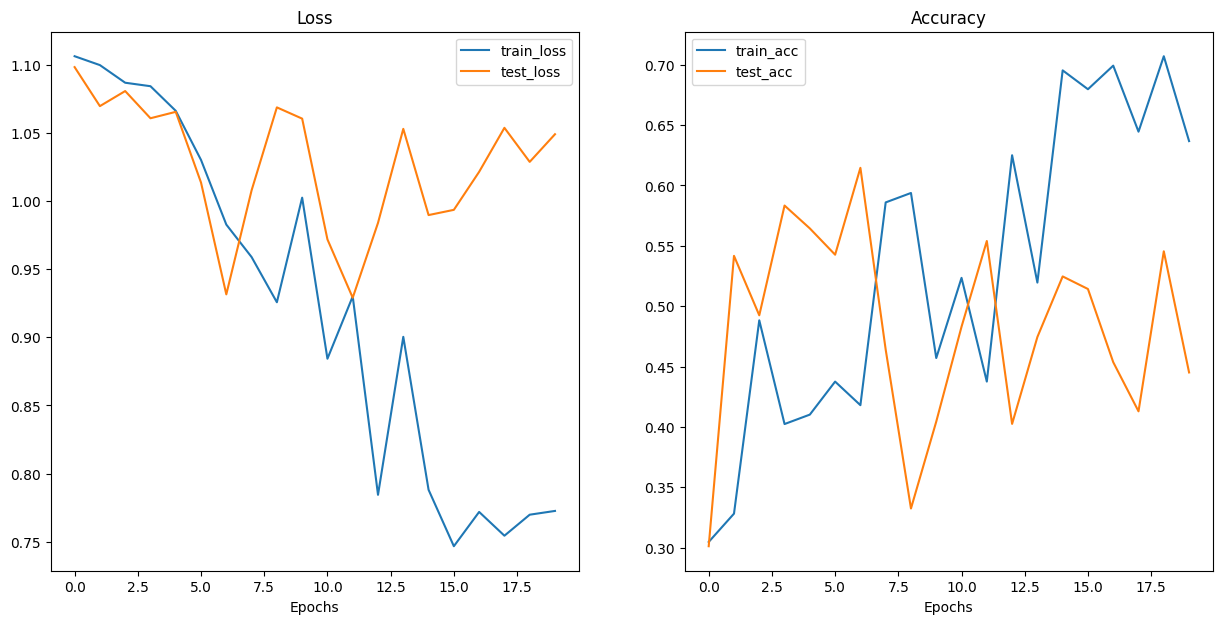

In [62]:
plot_loss_curves(model_0_results)

## 8. What Should an Ideal Loss Curve Look Like

* An overfitting model is one that performs better on the training set than the validation/test set.
* If your training loss is far lower that your test loss, your model is **overfitting**.
* When your training and test loss are not low as you'd like, this is considered as **underfitting**
* The ideal position for a training and test curve is for them to line up closely with each other

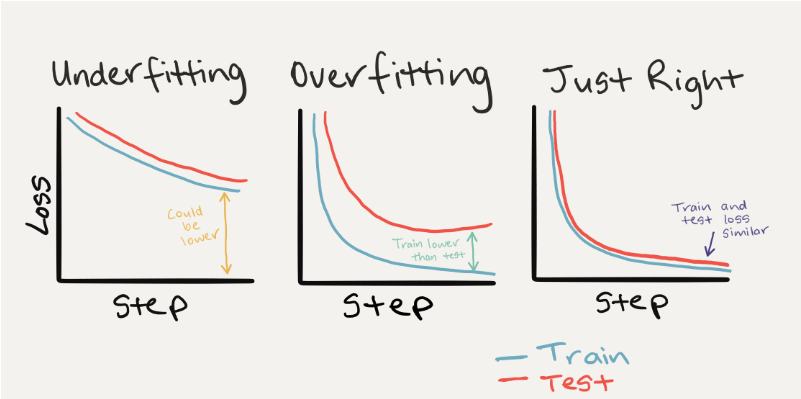


**Dealing with Overfitting**
- Get more data
- Data augmentation
- Better data
- Use transfer learning
- Simplify your model
- Use learning rate decay
- Use early stopping

**Dealing with Underfitting**
- Add more layers/units to your model
- Tweak the learning rate
- Train for longer
- Use transfer learning
- Use less regularization

## 9. Model 1: TinyVGG with Data Augmentation



### 9.1 Create transform with data augmentation

In [63]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset and Dataloaders with Augmentation

In [64]:
# Turn image folders into Dataset
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [65]:
# Turn our dataset into dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [66]:
model_1 = TinyVGG(input_shape=3,
                  hidden_units=16,
                  output_shape= len(train_data_augmented.classes)).to(device)



In [67]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

# Setup optimizer and loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

#Setup timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1049 | Train Acc: 0.2500 | Test Loss: 1.1044 | Test Acc: 0.2604
Epoch: 1 | Train Loss: 1.0862 | Train Acc: 0.4258 | Test Loss: 1.1210 | Test Acc: 0.2604
Epoch: 2 | Train Loss: 1.0736 | Train Acc: 0.4258 | Test Loss: 1.1457 | Test Acc: 0.2604
Epoch: 3 | Train Loss: 1.1218 | Train Acc: 0.3047 | Test Loss: 1.1429 | Test Acc: 0.2604
Epoch: 4 | Train Loss: 1.0765 | Train Acc: 0.4258 | Test Loss: 1.1173 | Test Acc: 0.2604
Epoch: 5 | Train Loss: 1.0936 | Train Acc: 0.3047 | Test Loss: 1.1238 | Test Acc: 0.2604
Epoch: 6 | Train Loss: 1.0708 | Train Acc: 0.4805 | Test Loss: 1.1196 | Test Acc: 0.2917
Epoch: 7 | Train Loss: 1.0610 | Train Acc: 0.4844 | Test Loss: 1.1247 | Test Acc: 0.2917
Epoch: 8 | Train Loss: 1.0960 | Train Acc: 0.3555 | Test Loss: 1.0739 | Test Acc: 0.3428
Epoch: 9 | Train Loss: 1.0754 | Train Acc: 0.4219 | Test Loss: 0.9941 | Test Acc: 0.5218
Epoch: 10 | Train Loss: 1.0217 | Train Acc: 0.4883 | Test Loss: 1.0265 | Test Acc: 0.4138
Epoch: 11 | Train Lo

### 9.4 Plot the loss curves of model_1

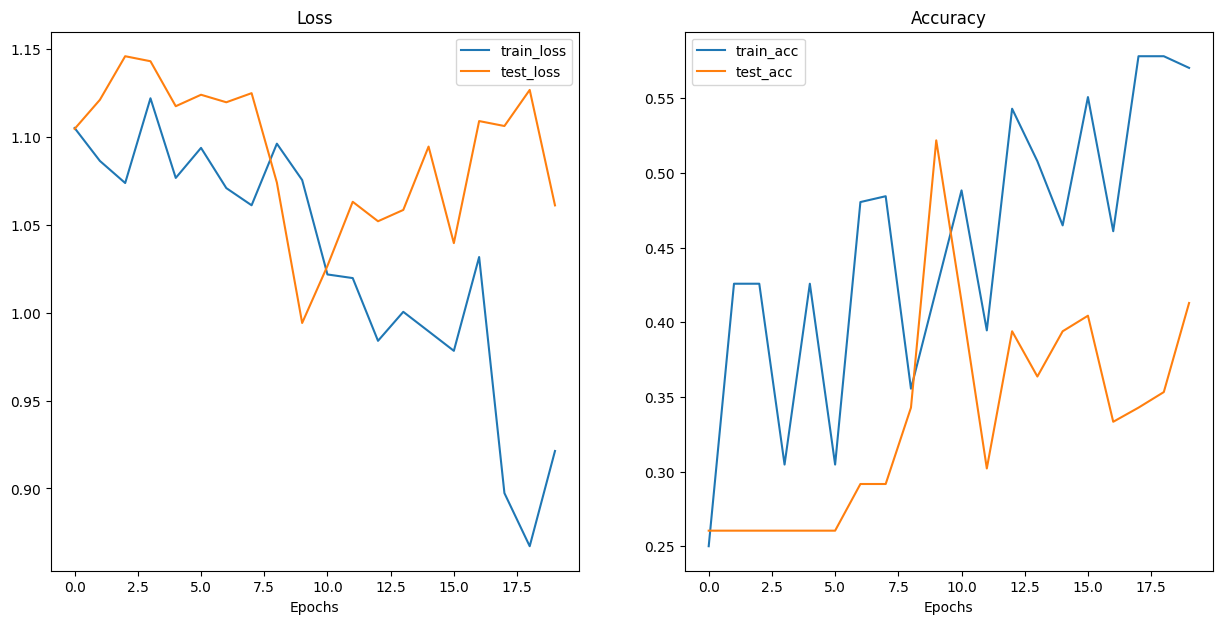

In [68]:
plot_loss_curves(model_1_results)

## 10. Compare Model Results

After evaluating our modeling experiments on their own, its important to compare them each other.


1. Hard coding
2. PyTorch + Tensorboard
3. Weights and Biases - [wandb](https://wandb.ai/site)
4. MLFlow -  [mlf](https://mlflow.org/)

In [69]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df.head(5)

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098321  0.301136
1    1.099803   0.328125   1.069699  0.541667
2    1.086867   0.488281   1.080753  0.492424
3    1.084311   0.402344   1.060794  0.583333
4    1.066243   0.410156   1.065495  0.564394

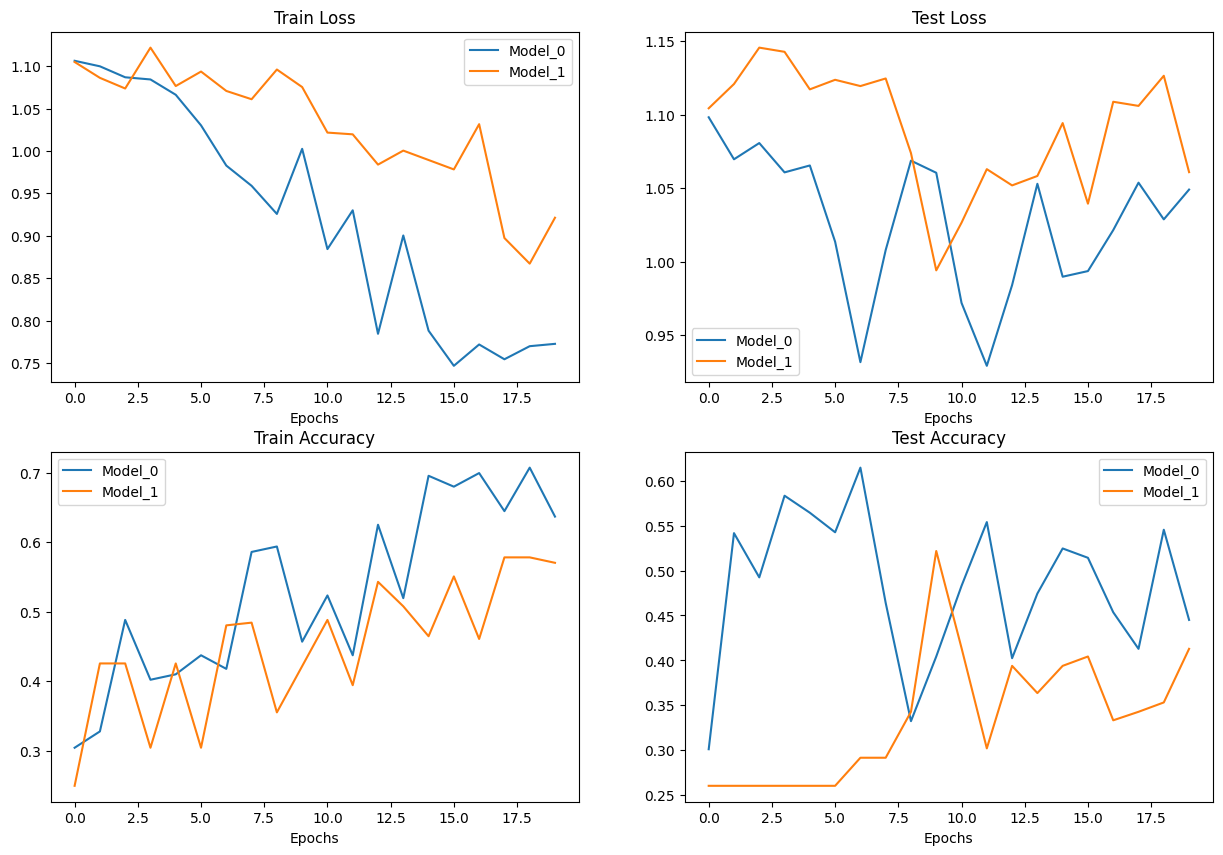

In [70]:
plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label= "Model_0")
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label= "Model_0")
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label= "Model_0")
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label= "Model_0")
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Make Prediction

In [73]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")



### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor from with datatype
* Of shape 3*64*64
* On the right device

In [74]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

### 11.2 Making a prediction on a custom image

In [75]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [76]:
# Load in the custom image and convert to torch.Float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

In [78]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x756765 and 2704x3)

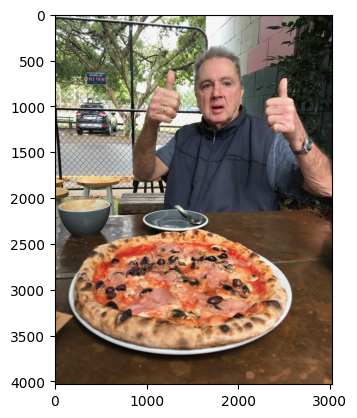

In [79]:
# Load in the custom image and convert to torch.Float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.

plt.imshow(custom_image.permute(1,2,0))

In [81]:
# Create transform pipelien to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


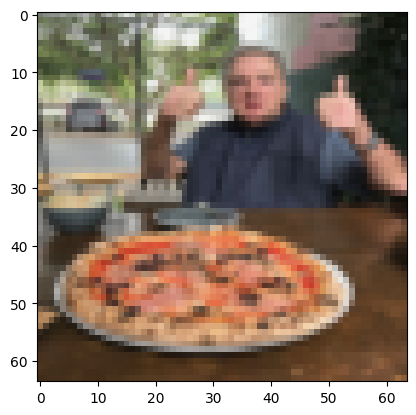

In [82]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [83]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x169 and 2704x3)

In [84]:
custom_image_transformed.shape # Need a batch dimension

torch.Size([3, 64, 64])

In [85]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [86]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

In [87]:
custom_image_pred

tensor([[ 0.2107, -0.2048, -0.8805]], device='cuda:0')

In [89]:
class_names

['pizza', 'steak', 'sushi']

Note, to make prediction on a custom image we had to:

- Load the image and turn it into a tensor
- Make sure the image was the same datatype as model
- Make sure the image was the same shape as the data the model was trained on (3,64,64) with a bathc size (1,3,64,64)
- Make sure the image was on the same device as our model

In [90]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.5010, 0.3307, 0.1683]], device='cuda:0')

In [92]:
# Convert prediction probs -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_labels

tensor([0])

In [93]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting Custom Image Prediction Together Building Function

Ideal outcome:

A function where we pass an image path to and have our model predict and plot the image+prediction

In [95]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  # Load image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  # Divide the image pixel values by 255 to get them between 0-1
  target_image = target_image / 255.
  # Transform if necessary
  if transform:
    target_image = transform(target_image)
  # Make sure model is on the target device
  model.to(device)

  # Turn on eval mode
  model.eval()
  with torch.inference_mode():
    # Add an extra dim for batch
    target_image = target_image.unsqueeze(0)
    # Make a prediction on the image
    target_image_pred = model(target_image.to(device))

  # Conver logits -> probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # Convert probs -> labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prob
  plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dim
  if class_names:
    title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)


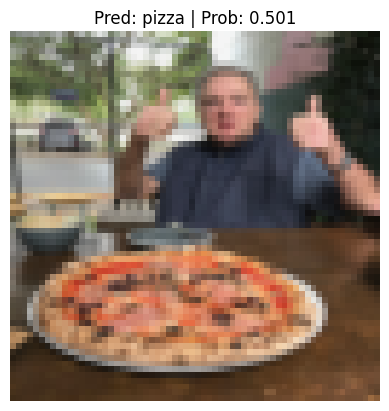

In [96]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)